<a href="https://colab.research.google.com/github/Nandhinisaravanann/OutriX_tasks/blob/main/OutriX_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### **IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os

##### **LOAD DATASET**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/OUTRIX/churn-bigml-20.csv')

In [ ]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

Shape: (667, 20)

Columns:
 ['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']


In [ ]:
# Display first rows to user
display(df.head(10))

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False
5,AK,36,408,No,Yes,30,146.3,128,24.87,162.5,80,13.81,129.3,109,5.82,14.5,6,3.92,0,False
6,MI,65,415,No,No,0,211.3,120,35.92,162.6,122,13.82,134.7,118,6.06,13.2,5,3.56,3,False
7,ID,119,415,No,No,0,159.1,114,27.05,231.3,117,19.66,143.2,91,6.44,8.8,3,2.38,5,True
8,VA,10,408,No,No,0,186.1,112,31.64,190.2,66,16.17,282.8,57,12.73,11.4,6,3.08,2,False
9,WI,68,415,No,No,0,148.8,70,25.30,246.5,164,20.95,129.8,103,5.84,12.1,3,3.27,3,False


##### **Data Cleaning & Exploration**

In [ ]:
print("\n--- Data types and missing values ---\n")
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())


--- Data types and missing values ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  To

In [ ]:
# Drop exact duplicates if any
before_dup = df.shape[0]
df = df.drop_duplicates()
after_dup = df.shape[0]
print(f"\nRows before dropping duplicates: {before_dup}, after: {after_dup}")


Rows before dropping duplicates: 667, after: 667


In [ ]:
# Quick value counts for target if present
target_col = None
for c in ['churn', 'Churn', 'churn?','Churn?','Churned']:
    if c in df.columns:
        target_col = c
        break

# fallback: try to detect binary column with 0/1 or True/False labelled 'Churn'
if target_col is None:
    # try to find a column with 0/1 named something with 'churn' in name
    for c in df.columns:
        if 'churn' in c.lower():
            target_col = c
            break

print("\nDetected target column:", target_col)

if target_col is None:
    raise ValueError("Couldn't detect churn target column automatically. Please tell me the column name.")

print("\nTarget value counts:\n", df[target_col].value_counts())

# Convert target to binary 0/1 if necessary
if df[target_col].dtype == object:
    df[target_col] = df[target_col].apply(lambda x: 1 if str(x).strip().lower() in ['yes','true','1','y'] else 0)
else:
    df[target_col] = df[target_col].astype(int)


Detected target column: Churn

Target value counts:
 Churn
False    572
True      95
Name: count, dtype: int64


##### **EDA Visualization**

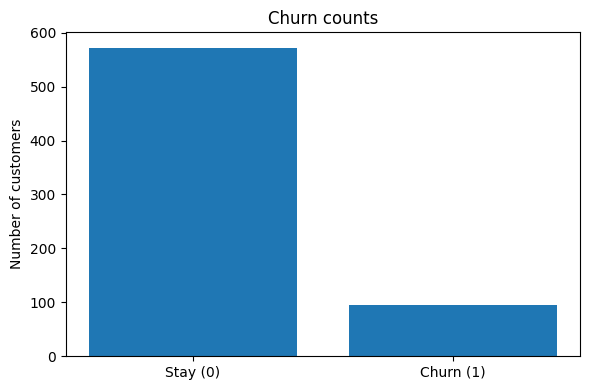


Numeric columns used for EDA: ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes']  (showing up to 10)
No tenure-like column detected automatically.
No monthly charge-like column detected automatically.


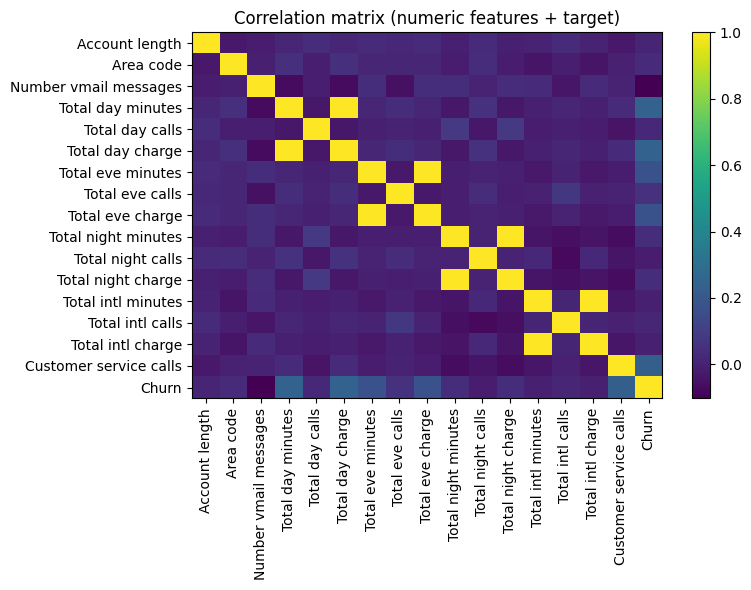

In [ ]:
# 1) Churn proportion bar chart
plt.figure(figsize=(6,4))
counts = df[target_col].value_counts().sort_index()
plt.bar(['Stay (0)','Churn (1)'], counts.values)
plt.title('Churn counts')
plt.ylabel('Number of customers')
plt.tight_layout()
plt.show()

# 2) Numeric distributions: choose numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove target from num_cols
num_cols = [c for c in num_cols if c != target_col]
print("\nNumeric columns used for EDA:", num_cols[:10], " (showing up to 10)")

# Tenure or similar column if exists
tenure_col = None
for c in ['tenure','Tenure','months','length','contract_duration']:
    if c in df.columns:
        tenure_col = c
        break

if tenure_col is not None:
    plt.figure(figsize=(6,4))
    plt.hist(df[tenure_col].dropna(), bins=30)
    plt.title(f'Distribution of {tenure_col}')
    plt.xlabel(tenure_col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("No tenure-like column detected automatically.")

# 3) MonthlyCharges (or similar) vs churn scatter if exists
money_col = None
for c in ['MonthlyCharges','monthly_charges','Monthly Charge','monthlycharge','avg_monthly_charges','TotalCharges']:
    if c in df.columns:
        money_col = c
        break

if money_col is not None:
    plt.figure(figsize=(6,4))
    plt.scatter(df[money_col], df[target_col], alpha=0.3)
    plt.xlabel(money_col)
    plt.ylabel('Churn (1)')
    plt.title(f'{money_col} vs Churn (scatter)')
    plt.tight_layout()
    plt.show()
else:
    print("No monthly charge-like column detected automatically.")

# 4) Correlation heatmap for numeric features (matplotlib imshow)
if len(num_cols) >= 2:
    corr = df[num_cols + [target_col]].corr()
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title('Correlation matrix (numeric features + target)')
    plt.tight_layout()
    plt.show()

##### **FEATURE ENGINEERING**

In [ ]:
# Select features: use most columns except identifiers and target
# drop columns that look like IDs or name fields
drop_like = [c for c in df.columns if 'id' in c.lower() or 'name' in c.lower() or 'customer'==c.lower()]
features = [c for c in df.columns if c not in drop_like + [target_col]]
print("\nInitial feature set size:", len(features))

# Split into X and y
X = df[features].copy()
y = df[target_col].copy()

# Identify categorical and numeric features for preprocessing
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("\nCategorical columns:", cat_cols[:20])
print("Numeric columns:", num_cols[:20])

# Simple imputation + one-hot for categoricals, scaling for numeric
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# Prepare train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Create full pipeline with RandomForest
clf = Pipeline(steps=[
    ('pre', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

print("\nTraining Random Forest classifier... (this may take a moment)")
clf.fit(X_train, y_train)
print("Training completed.")


Initial feature set size: 19

Categorical columns: ['State', 'International plan', 'Voice mail plan']
Numeric columns: ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']

Training Random Forest classifier... (this may take a moment)
Training completed.


##### **MODEL EVALUATION**


ROC AUC on test set: 0.9108


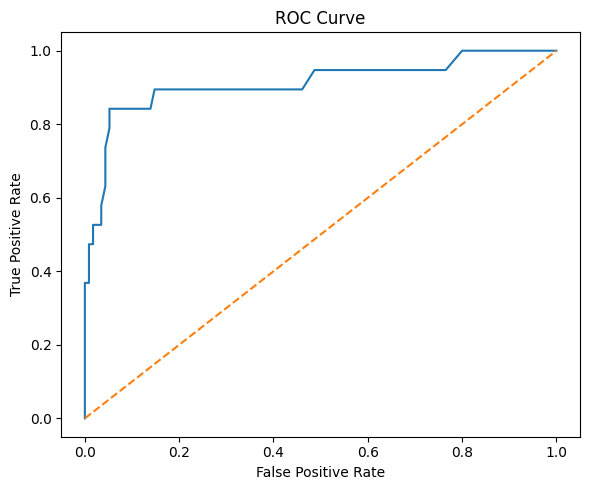

Precision at top 1%: 1.0
Precision at top 5%: 1.0
Precision at top 10%: 0.875
Precision at top 20%: 0.875


In [ ]:
# Predict probabilities on test set
y_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
roc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC on test set: {roc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.tight_layout()
plt.show()

# Precision at K (precision among top K% predicted highest churners)
def precision_at_k(y_true, y_scores, k=0.1):
    # k is fraction
    assert 0 < k <= 1.0
    n = int(len(y_scores) * k)
    if n < 1:
        return None
    idx = np.argsort(y_scores)[-n:][::-1]  # indices of top n scores
    return precision_score(y_true.iloc[idx], (y_scores[idx] >= 0.5).astype(int))  # thresholded at 0.5 for safety

for k in [0.01, 0.05, 0.1, 0.2]:
    pk = precision_at_k(y_test.reset_index(drop=True), y_proba, k=k)
    print(f"Precision at top {int(k*100)}%: {pk}")

,feature,importance
0,Total day charge,0.126677
1,Total day minutes,0.120163
2,Customer service calls,0.085078
3,Total eve charge,0.075463
4,Total eve minutes,0.069763
5,Total night charge,0.040049
6,Total eve calls,0.038071
7,Total intl minutes,0.037627
8,Total intl charge,0.037399
9,Total day calls,0.036704


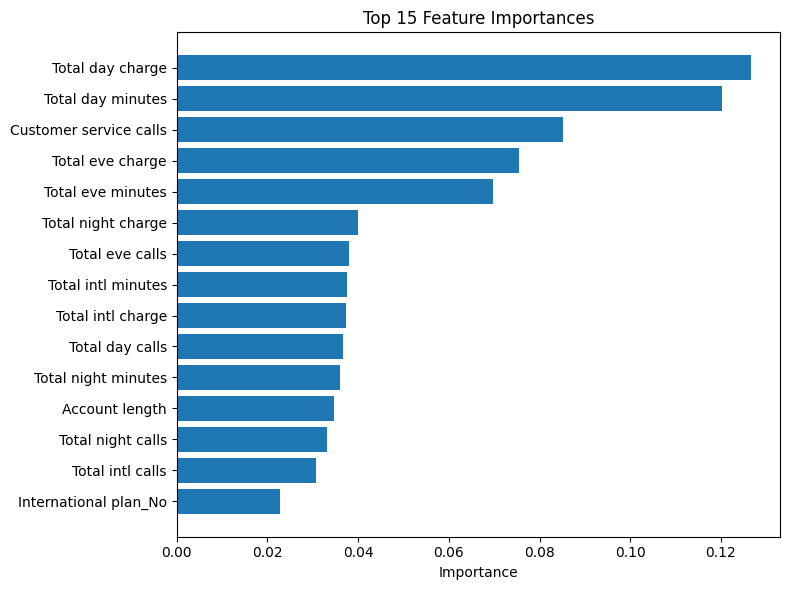

In [ ]:
# Feature importance: extract feature names after preprocessing
# get numeric feature names and categorical one-hot names
num_features_names = num_cols
cat_features_names = []
if len(cat_cols) > 0:
    onehot = clf.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
    cat_features_names = list(onehot.get_feature_names_out(cat_cols))

feature_names = num_features_names + cat_features_names
importances = clf.named_steps['rf'].feature_importances_

# Create importance DF and plot top 15
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi = fi.sort_values('importance', ascending=False).reset_index(drop=True)
display(fi.head(30))

plt.figure(figsize=(8,6))
topn = fi.head(15)
plt.barh(topn['feature'][::-1], topn['importance'][::-1])
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Export churn scores for full dataset
full_proba = clf.predict_proba(X)[:,1]
out = df.copy()
out['churn_score'] = full_proba
out = out.sort_values('churn_score', ascending=False).reset_index(drop=True)

out_path = "/tmp/churn_scores.csv"
out.to_csv(out_path, index=False)
print(f"\nExported churn scores to: {out_path} (top 10 shown below)")
display(out.head(10))


Exported churn scores to: /tmp/churn_scores.csv (top 10 shown below)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,churn_score
0,SC,87,408,No,No,0,322.5,106,54.83,204.6,...,17.39,186.2,128,8.38,9.4,4,2.54,2,1,0.960
1,NY,161,415,No,No,0,332.9,67,56.59,317.8,...,27.01,160.6,128,7.23,5.4,9,1.46,4,1,0.935
2,MS,29,510,No,No,0,313.2,103,53.24,216.3,...,18.39,218.4,106,9.83,12.8,4,3.46,2,1,0.935
3,MD,133,510,No,No,0,295.0,141,50.15,223.6,...,19.01,229.4,109,10.32,12.9,4,3.48,2,1,0.935
4,ME,80,408,No,No,0,322.3,113,54.79,222.0,...,18.87,162.8,123,7.33,6.7,8,1.81,0,1,0.925
5,DE,129,510,No,No,0,334.3,118,56.83,192.1,...,16.33,191.0,83,8.59,10.4,6,2.81,0,1,0.910
6,WA,84,415,No,No,0,289.1,100,49.15,233.8,...,19.87,223.5,148,10.06,12.7,2,3.43,2,1,0.900
7,WY,134,510,No,No,0,296.0,93,50.32,226.4,...,19.24,246.8,98,11.11,12.3,10,3.32,0,1,0.895
8,OK,89,510,No,No,0,303.9,95,51.66,260.9,...,22.18,312.1,89,14.04,5.3,3,1.43,1,1,0.895
9,NJ,80,415,No,No,0,268.7,120,45.68,301.0,...,25.59,167.0,140,7.52,5.8,1,1.57,2,1,0.885
